# Illustrated Linear Quadratic Regulator

Companion to courses lectures from [CS6756: Learning for Robot Decision Making](https://www.cs.cornell.edu/courses/cs6756/2022fa/) and Chapter 2 of [Modern Adaptive Control and Reinforcement Learning](https://drive.google.com/file/d/1SGMdtjpP8-Yxga2ph-tUWBcFx5cH89t2/view).

In [3]:
import numpy as np
import autograd.numpy as np
from autograd import grad, jacobian
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc
from IPython.display import HTML, Image
from matplotlib.patches import Circle
rc('animation', html='jshtml')

# Dynamics of an Inverted Pendulum 

In [43]:
# Constants
g = 9.8
l = 1.0
m = 1.0

def inverted_pendulum_dynamics(x, u, dt=0.1, control_noise=None, dynamics_noise=None):
  if control_noise is not None:
    u = u + control_noise*np.random.randn(*u.shape)

  theta_ddot = g/l * np.sin(x[0]) + (1/(m*l**2)) * u
  x_new = x + np.array([x[1]*dt + 0.5*theta_ddot[0]*dt**2, theta_ddot[0]*dt])

  if dynamics_noise is not None:
    x_new = x_new + dynamics_noise*np.random.randn(*x_new.shape)

  return x_new

# The Linear Quadratic Regulator

## Building the LQR matrices

In [12]:
# Dynamics matrices
dyn_x = jacobian(inverted_pendulum_dynamics, 0)
dyn_u = jacobian(inverted_pendulum_dynamics, 1)

x_ref = np.array([0., 0.])
u_ref = np.array([0.])
A = dyn_x(x_ref, u_ref)
B = dyn_u(x_ref, u_ref)

# Cost function matrices
Q = np.array([[1, 0], [0, 1]])
R = 1*np.eye(1)

## LQR Value Iteration

In [9]:
# Dynamic programming to compute K and V matrices backwards in time
def lqr_value_iteration(A, B, Q, R, H):
  V = Q 
  K = np.zeros((1,2)) 
  V_list = [V]
  K_list = [K]
  for t in range(H-2, -1, -1):
    K = -np.linalg.inv(R + B.T @ V @ B) @ (B.T @ V @ A)
    V = Q + K.T @ R @ K + np.transpose(A + B @ K) @ V @ (A + B @ K)
    V_list += [V]
    K_list += [K]
  return V_list, K_list

In [7]:
# Function for creating an animation of values and policies
def animate_value(V_list, save_filename=None):
  value = lambda x, y, V: V[0,0] * x**2 + V[1,1] * y**2 + (V[0,1]+V[1,0]) * x * y
  x = np.linspace(-1, 1, 100)
  y = np.linspace(-1, 1, 100)
  X, Y = np.meshgrid(x, y)
  plt.style.use('dark_background')

  fig = plt.figure()
  plt.gca().set_aspect("equal")
  Z = value(X, Y, V_list[0])

  global cont # TODO: remove this global nonsense. 
  cont = plt.contourf(X, Y, Z, 20, cmap='YlOrRd')
  ttl = plt.text(-.25, 1.02, '')

  # animation function
  def animate(i):
      global cont
      Z = value(X, Y, V_list[i])
      for c in cont.collections:
          c.remove()  # removes only the contours, leaves the rest intact
      cont = plt.contourf(X, Y, Z, 20, cmap='YlOrRd')
      ttl.set_text(f'Time: {len(V_list)-i}')
      return cont

  anim = FuncAnimation(fig, animate, frames=len(V_list), blit=False, repeat=False)
  if save_filename is not None:
    anim.save(save_filename, writer = "pillow", fps=15)  
  return anim

Let's test out how the value function evolves backwards in time!

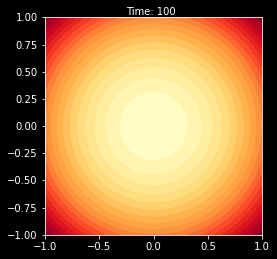

In [18]:
V_list, K_list = lqr_value_iteration(A, B, Q, R, H=100)
animate_value(V_list, save_filename='lqr_value_iteration.gif')

## Running the controller

In [44]:
def forward_simulate(x_0, K, H, control_noise=None, dynamics_noise=None):
  x_traj, u_traj = [], []
  x = x_0
  for t in range(H):
    u = K @ x
    x_traj.append(x)
    u_traj.append(u)
    x = inverted_pendulum_dynamics(x, u, control_noise=control_noise, dynamics_noise=dynamics_noise)
  return x_traj, u_traj

In [45]:
def animate_pendulum(x_traj, save_filename=None):
  plt.style.use('dark_background')
  fig = plt.figure()
  ax = fig.add_subplot(aspect='equal')
  plt.axis('off')
  x = x_traj[0]
  line, = ax.plot([0, x[0]], [0, x[1]], lw=3, c='w')
  bob_radius = 0.08
  circle = ax.add_patch(plt.Circle((x[0], x[1]), bob_radius, fc='tab:orange', zorder=3))
  ax.set_xlim(-l*0.8, l*0.8)
  ax.set_ylim(0.0, l*1.2)

  def draw_pendulum(i):
      """Update the animation at frame i."""
      x = x_traj[i]
      x, y = -l*np.sin(x[0]), l*np.cos(x[0])
      line.set_data([0, x], [0, y])
      circle.set_center((x, y))

  anim = FuncAnimation(fig, draw_pendulum, frames=100, blit=False, repeat=False)
  if save_filename is not None:
    anim.save(save_filename, writer='pillow', fps=15)
  return anim

In [62]:
def animate_phase_space(x_traj, V_f, save_filename=None):
  value = lambda x, y, V: V[0,0] * x**2 + V[1,1] * y**2 + (V[0,1]+V[1,0]) * x * y
  x = np.linspace(-1, 1, 100)
  y = np.linspace(-1, 1, 100)
  X, Y = np.meshgrid(x, y)
  plt.style.use('dark_background')
  fig = plt.figure()
  plt.gca().set_aspect("equal")
  Z = value(X, Y, V_f)
  plt.contourf(X, Y, Z, 20, cmap='YlOrRd')
  x = x_traj[0]
  point, = plt.plot([x[0]], [x[1]], '-k.', markersize=20)
  ttl = plt.text(-.25, 1.02, '')

  def draw_state_space(i):
      """Update the animation at frame i."""
      x = x_traj[i]
      point.set_data([x[0]], [x[1]])
      ttl.set_text('Time: {}'.format(i))

  anim = FuncAnimation(fig, draw_state_space, frames=100, blit=False, repeat=False)
  if save_filename is not None:
    anim.save(save_filename, writer='pillow', fps=15)
  return anim

## Easy setting

Let's test the controller from an easy starting position where it's falling towards the equillibrium anyways

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


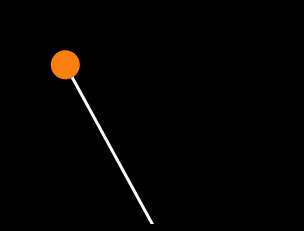

In [63]:
x_0 = np.array([[0.5], [-0.5]])
control_noise = 0.5
dyanmics_noise = np.array(([0.0], [0.05]))
x_traj, u_traj = forward_simulate(x_0, K_list[-1], H=100, control_noise = control_noise, dynamics_noise = dyanmics_noise)
animate_pendulum(x_traj, save_filename='easy_init_pendulum.gif')

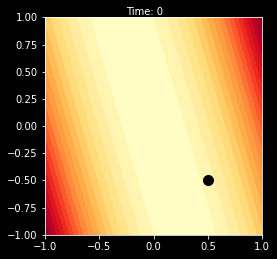

In [64]:
animate_phase_space(x_traj, V_list[-1], save_filename='easy_init_phase_space.gif')

## Hard Setting

Let's test the controller when beginning at a harder initialization point, i.e. falling away from the equillibrium

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


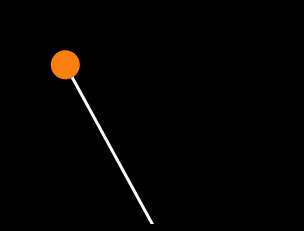

In [66]:
x_0 = np.array([[0.5], [0.5]])
control_noise = 0.5
dyanmics_noise = np.array(([0.0], [0.05]))
x_traj, u_traj = forward_simulate(x_0, K_list[-1], H=100, control_noise = control_noise, dynamics_noise = dyanmics_noise)
animate_pendulum(x_traj, save_filename='hard_init_pendulum.gif')

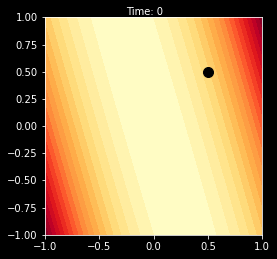

In [67]:
animate_phase_space(x_traj, V_list[-1], save_filename='hard_init_phase_space.gif')